### Cyper-physical Systems Programming Exam
by Benedikte Petersen, Natalia Anna Prokopiuk, Stijn Kolkman

## About the project

The objective of the project is to adapt an original code of a DVS camera simuator that changes video frames to Dynamic Vison Sensor frames, so that it is able to perform batch processing (process multiple input videos simultaneously).

Instead of taking as an input a frame of size (height, width, channels) for each timestep, the simulator now takes a torch tensor with size (batch_size, height, width, channels).

The code is adapted to run on a GPU and process in parallel.

## Resources

The full project code can be found at https://github.com/StijnKolkman/Project_cpsp-v2eV3.

The original code is made by the Swiss National Competence Center for Robotics (https://github.com/SensorsINI/v2e).

## Setup and enviromental requirements

The required enviroment setup can be found at the original github page (https://github.com/SensorsINI/v2e). Follow the instructions for local installation.

**ATTENTION**: The orignal guide requests CUDA, however the new code will run on the CPU if CUDA is not supported. When cloning the  github enviroment use https://github.com/StijnKolkman/Project_cpsp-v2eV3.

## Main idea

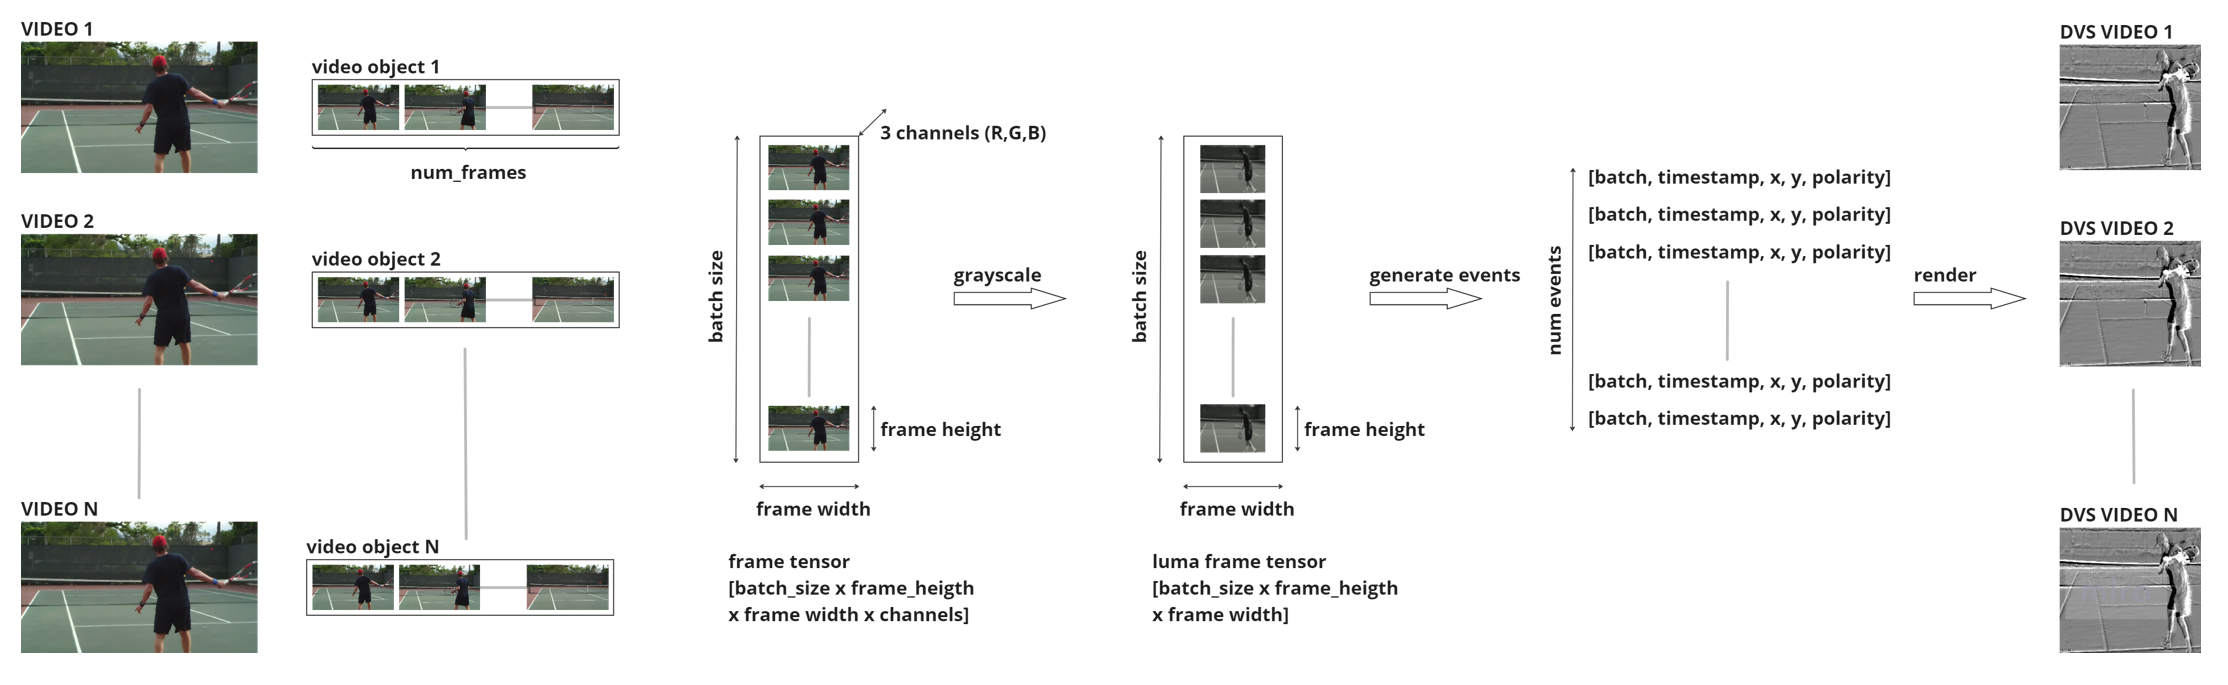


## About the process

To convert the code to support batch processing the following files were created:
- <b>NewMain.py</b>

    Process the input videos simultaneously to extract frames and create a luma frame tensor to be passed to the generate_events function
- <b>emulatorNew.py</b>

    Implement the emulator, in particular the generate_events function and the internal functions, so that they are able to work with batches
- <b>emulator_utilsNew.py</b>

    Functions used by the emulatorNew
- <b>RenderNew.py</b>

    Render videos based on events returned by generate_events function

## NewMain - code walkthrough

Below is presented the suggested way to use the modified emulator.

Import libraries:

In [1]:
from v2ecore.emulatorNew import EventEmulator                       # Import the v2e simulator
import torch                                                        # Torch
import cv2                                                          # To read video using OpenCV
import glob                                                         # Manage files

Configuration:

In [2]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # This allows it to work on a cpu
print(f"Device: {device}")
video_folder = 'input/*.mov'

Device: cpu


Read video files (imported to your local input folder):

In [3]:
# Read video files
video_files = glob.glob(video_folder)                           # List of paths to the videos
batch_size = len(video_files)                                   # The batch size is equal to the amount of videos
if batch_size == 0:
    print("No video files found in the specified folder.")
    exit()

Define and setup the emulator:

In [4]:
# define the emulator (set the settings of the emulator)
emulatorNew = EventEmulator(
    pos_thres           = 0.5,
    neg_thres           = 0.5,
    sigma_thres         = 0.03,
    cutoff_hz           = 200,
    leak_rate_hz        = 0.0001, 
    batch_size          = batch_size,
    device              = device,
    refractory_period_s = 0.01,
    output_folder       = 'output/',

    # having this will allow H5 output
    dvs_h5              = 'eventsH5',

    # Other possible output format
    dvs_aedat2          = None, #currently doesnt work with batch processing
    dvs_aedat4          = None, #currently doesnt work with batch processing
    dvs_text            = None, #currently doesnt work with batch processing

    # True when the input is in hdr format (then it will skip the linlog conversion step)
    hdr                 = False,

    # If True, photoreceptor noise is added to the simulation
    photoreceptor_noise = False,

    #CSDVS --> This will enable csdvs, this function currently does not work with batch processing, so keep at None
    cs_lambda_pixels    = None,

    #scidvs
    scidvs              = False,

    # Parameter to show an image and to save it to an avi file. If show_dvs_model_state is enabled it will output the frames and will wait for a key press before it continues. Pressing 'x' will quite the process
    show_dvs_model_state = ['new_frame','diff_frame','lp_log_frame'], # options:['all','new_frame', 'log_new_frame','lp_log_frame', 'scidvs_highpass', 'photoreceptor_noise_arr', 'cs_surround_frame','c_minus_s_frame', 'base_log_frame', 'diff_frame'])
    output_height       =200, #output height of the windowg
    output_width        =200,
    save_dvs_model_state= True,

    #define shot noise or not 
    shot_noise_rate_hz  = 0,
    label_signal_noise  = False, #Currently doesnt work with batch processing and also doesnt work in the original code

    #record the state of a single pixel (input is tuple)
    record_single_pixel_states = (1, 10, 20) #example tuple containing pixel info: batch, height, width
)
# **IMPORTANT** make torch static, likely get faster emulation (might also cause memory issue)
torch.set_grad_enabled(False)

Initialize variables:

In [5]:
# Initialize variables
caps        = []                           #here the videos will be saved
fps           = 0                          #fps of the videos, should be same for th videos
num_of_frames = 0                          #total number of frames. Should be the same for every video
duration      = 0                          # Duration of the videos, should be the same for every video
delta_t       = 0                          #The time between two frames. IS ASSUMED TO BE THE SAME FOR EVERY VIDEO
current_time  = 0                          #Current time is not a tensor anymore since we can assume that every video has the same size

Read the frames and get information about the videos:

In [6]:
#loop over the videos in the input folder to get the frames and the information (fps, num_of_frames, duration, delta_t, current_time)
print() 
for i, video_file in enumerate(video_files): 
    print(f"Opening video {i+1}: {video_file}")
    cap = cv2.VideoCapture(video_file)

    if not cap.isOpened(): 
        print(f"Error opening video file: {video_file}")
        continue

    # Append the VideoCapture object to the list
    caps.append(cap)

    # Get the information
    fps = cap.get(cv2.CAP_PROP_FPS)
    print("FPS: {}".format(fps))
    num_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Num of frames: {}".format(num_of_frames))
    duration = num_of_frames/fps
    print("Clip Duration: {}s".format(duration))
    delta_t = 1/fps                                    
    print("Delta Frame Time: {}s".format(delta_t))
    print()


Opening video 1: input\tennis — kopia.mov
FPS: 59.94007280921804
Num of frames: 1551
Clip Duration: 25.875844444444443s
Delta Frame Time: 0.016683329751414858s

Opening video 2: input\tennis.mov
FPS: 59.94007280921804
Num of frames: 1551
Clip Duration: 25.875844444444443s
Delta Frame Time: 0.016683329751414858s



Define tensors and initialize the remaining parameters. Set the *max_height* and *max_width* values, so that they correspond to your videos:

In [7]:
new_events = None                                           #Initialize the new_events. Will be filled by the emulator with events
idx        = 0                                              #Initialize counter
ret        = torch.zeros(batch_size,device=device)          #Tensor that stores the return value of cap.read()


max_height  = 720                                                                        # Example video height
max_width   = 1280                                                                       # Example video width
channels    = 3                                                                          # RGB
frame_tensor = torch.zeros((batch_size, max_height, max_width, channels), device=device) # Tensor containing the frames
luma_frame_tensor = torch.zeros((batch_size, max_height, max_width), device=device)      # Tensor containing the luma_frames
weights     = torch.tensor([0.299, 0.587, 0.114],device=device).view(1, 1, 1, 3)         # Weights for transfer to grayscale, see:https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html#color_convert_rgb_gray 

Set the maximum amount of frames to read:

*(Optional and used to reduce the time needed for testing. Turn off to work with full videos)*

In [8]:
N_frames   = 20                                             #Only Emulate the first N_frames of every video

Run the loop to generate events:

In [9]:
while True:
    all_ret_false = True  # Flag to determine if all videos are done

    for i, cap in enumerate(caps):
        ret, frame_read = cap.read() 
        if ret:
            all_ret_false = False
            frame_tensor[i] = torch.from_numpy(frame_read).float().to(device)  # Convert frame (np array) to tensor
            #print("Size of frame_tensor[{}]: {}".format(i, frame_tensor[i].size()))
        else:
            # Append a zero tensor if video is finished
            frame_tensor[i] = torch.zeros((max_height, max_width), device=device) #Not really needed anymore since it is assumed that all files will have the same number of frames

    if all_ret_false:  # Stop if all videos are done
        break
    #print("Size of frame_tensor: {}".format(frame_tensor.size()))
    luma_frame_tensor = (frame_tensor * weights).sum(dim=-1)  # Compute luma frame
    #print("Size of luma_frame_tensor: {}".format(luma_frame_tensor.size()))
    # Generate events
    print("="*50)
    print(f"Processing frame_batch {idx + 1} of in total {N_frames} frame_batches")
    print("="*50)
    new_events = emulatorNew.generate_events(luma_frame_tensor, current_time)

    # Update current time
    current_time += delta_t

    # printing some events to look at the output
    if current_time > delta_t:
        print('Now going to print some events for you (batch, time, x, y, polarity):')
        print(new_events[0:4,:])

    # Log event statistics for the batch
    if new_events is not None:
        num_events = new_events.shape[0]
        start_t = new_events[0, 1]
        end_t = new_events[-1, 1]
        event_time = (new_events[-1, 1]-new_events[0, 1])
        event_rate_kevs = (num_events/delta_t)/1e3
        print("Number of Events: {}\n"
            "Duration: {}s\n"
            "Start T: {:.5f}s\n"
            "End T: {:.5f}s\n"
            "Event Rate: {:.2f}KEV/s".format(
                num_events, event_time, start_t, end_t,
                event_rate_kevs))

    print("="*50)
    idx += 1
    if idx >= N_frames:  # Limit for testing
        break

Processing frame_batch 1 of in total 20 frame_batches


IIR lowpass filter update has large maximum update eps=20.96 from delta_time/tau=0.0167/0.000796


Processing frame_batch 2 of in total 20 frame_batches


IIR lowpass filter update has large maximum update eps=20.96 from delta_time/tau=0.0167/0.000796


Maximum number of events generated in each batch: [7, 6]
The size of ts is:  torch.Size([2, 7])
Now going to print some events for you (batch, time, x, y, polarity):
[[ 0.0000000e+00  2.3833327e-03  1.0060000e+03  2.7700000e+02
  -1.0000000e+00]
 [ 1.0000000e+00  2.3833327e-03  1.0470000e+03  9.9000000e+01
   1.0000000e+00]
 [ 1.0000000e+00  2.3833327e-03  9.7100000e+02  1.9600000e+02
   1.0000000e+00]
 [ 1.0000000e+00  2.3833327e-03  1.0090000e+03  2.9600000e+02
  -1.0000000e+00]]
Number of Events: 60079
Duration: 0.011916663497686386s
Start T: 0.00238s
End T: 0.01430s
Event Rate: 3601.14KEV/s
Processing frame_batch 3 of in total 20 frame_batches


IIR lowpass filter update has large maximum update eps=20.94 from delta_time/tau=0.0167/0.000796


Maximum number of events generated in each batch: [6, 6]
The size of ts is:  torch.Size([2, 6])
Now going to print some events for you (batch, time, x, y, polarity):
[[ 0.0000000e+00  1.9463884e-02  9.4400000e+02  2.2700000e+02
  -1.0000000e+00]
 [ 1.0000000e+00  1.9463884e-02  1.0150000e+03  3.4800000e+02
  -1.0000000e+00]
 [ 0.0000000e+00  1.9463884e-02  1.1170000e+03  2.8800000e+02
   1.0000000e+00]
 [ 0.0000000e+00  1.9463884e-02  1.1680000e+03  3.7100000e+02
   1.0000000e+00]]
Number of Events: 88752
Duration: 0.011122219264507294s
Start T: 0.01946s
End T: 0.03059s
Event Rate: 5319.80KEV/s
Processing frame_batch 4 of in total 20 frame_batches


IIR lowpass filter update has large maximum update eps=20.93 from delta_time/tau=0.0167/0.000796


Maximum number of events generated in each batch: [6, 6]
The size of ts is:  torch.Size([2, 6])
Now going to print some events for you (batch, time, x, y, polarity):
[[ 1.0000000e+00  3.6147214e-02  1.1500000e+03  6.0800000e+02
   1.0000000e+00]
 [ 0.0000000e+00  3.6147214e-02  2.9300000e+02  3.4300000e+02
  -1.0000000e+00]
 [ 1.0000000e+00  3.6147214e-02  1.6600000e+02  7.1900000e+02
   1.0000000e+00]
 [ 0.0000000e+00  3.6147214e-02  8.4000000e+02  2.2300000e+02
  -1.0000000e+00]]
Number of Events: 82017
Duration: 0.011122219264507294s
Start T: 0.03615s
End T: 0.04727s
Event Rate: 4916.10KEV/s
Processing frame_batch 5 of in total 20 frame_batches


IIR lowpass filter update has large maximum update eps=20.94 from delta_time/tau=0.0167/0.000796


Maximum number of events generated in each batch: [7, 7]
The size of ts is:  torch.Size([2, 7])
Now going to print some events for you (batch, time, x, y, polarity):
[[ 0.0000000e+00  5.2433323e-02  1.1520000e+03  3.3900000e+02
   1.0000000e+00]
 [ 0.0000000e+00  5.2433323e-02  1.1380000e+03  4.6200000e+02
   1.0000000e+00]
 [ 0.0000000e+00  5.2433323e-02  1.2000000e+03  6.9400000e+02
  -1.0000000e+00]
 [ 1.0000000e+00  5.2433323e-02  1.1500000e+03  1.4500000e+02
  -1.0000000e+00]]
Number of Events: 102769
Duration: 0.011916663497686386s
Start T: 0.05243s
End T: 0.06435s
Event Rate: 6159.98KEV/s
Processing frame_batch 6 of in total 20 frame_batches


IIR lowpass filter update has large maximum update eps=20.94 from delta_time/tau=0.0167/0.000796


Maximum number of events generated in each batch: [9, 8]
The size of ts is:  torch.Size([2, 9])
Now going to print some events for you (batch, time, x, y, polarity):
[[ 0.000000e+00  6.858702e-02  9.980000e+02  2.750000e+02 -1.000000e+00]
 [ 0.000000e+00  6.858702e-02  2.980000e+02  7.080000e+02  1.000000e+00]
 [ 1.000000e+00  6.858702e-02  9.130000e+02  3.340000e+02  1.000000e+00]
 [ 0.000000e+00  6.858702e-02  2.970000e+02  2.160000e+02 -1.000000e+00]]
Number of Events: 120775
Duration: 0.011122219264507294s
Start T: 0.06859s
End T: 0.07971s
Event Rate: 7239.26KEV/s
Processing frame_batch 7 of in total 20 frame_batches


IIR lowpass filter update has large maximum update eps=20.96 from delta_time/tau=0.0167/0.000796


Maximum number of events generated in each batch: [7, 6]
The size of ts is:  torch.Size([2, 7])
Now going to print some events for you (batch, time, x, y, polarity):
[[ 0.000000e+00  8.579998e-02  6.160000e+02  2.150000e+02 -1.000000e+00]
 [ 0.000000e+00  8.579998e-02  1.146000e+03  1.610000e+02 -1.000000e+00]
 [ 0.000000e+00  8.579998e-02  3.000000e+01  1.850000e+02  1.000000e+00]
 [ 0.000000e+00  8.579998e-02  1.229000e+03  1.380000e+02  1.000000e+00]]
Number of Events: 112645
Duration: 0.011916667222976685s
Start T: 0.08580s
End T: 0.09772s
Event Rate: 6751.95KEV/s
Processing frame_batch 8 of in total 20 frame_batches


IIR lowpass filter update has large maximum update eps=20.92 from delta_time/tau=0.0167/0.000796


Maximum number of events generated in each batch: [7, 8]
The size of ts is:  torch.Size([2, 8])
Now going to print some events for you (batch, time, x, y, polarity):
[[ 1.000000e+00  1.021854e-01  1.054000e+03  5.580000e+02 -1.000000e+00]
 [ 0.000000e+00  1.021854e-01  7.100000e+02  2.130000e+02 -1.000000e+00]
 [ 0.000000e+00  1.021854e-01  1.115000e+03  3.140000e+02  1.000000e+00]
 [ 0.000000e+00  1.021854e-01  1.093000e+03  1.870000e+02  1.000000e+00]]
Number of Events: 127766
Duration: 0.0104270800948143s
Start T: 0.10219s
End T: 0.11261s
Event Rate: 7658.30KEV/s
Processing frame_batch 9 of in total 20 frame_batches


IIR lowpass filter update has large maximum update eps=20.90 from delta_time/tau=0.0167/0.000796


Maximum number of events generated in each batch: [7, 7]
The size of ts is:  torch.Size([2, 7])
Now going to print some events for you (batch, time, x, y, polarity):
[[ 1.0000000e+00  1.1916664e-01  1.1200000e+02  1.9700000e+02
  -1.0000000e+00]
 [ 1.0000000e+00  1.1916664e-01  1.1250000e+03  1.4400000e+02
  -1.0000000e+00]
 [ 0.0000000e+00  1.1916664e-01  9.9700000e+02  3.7000000e+02
  -1.0000000e+00]
 [ 0.0000000e+00  1.1916664e-01  1.5700000e+02  2.7900000e+02
   1.0000000e+00]]
Number of Events: 149950
Duration: 0.01191665232181549s
Start T: 0.11917s
End T: 0.13108s
Event Rate: 8988.01KEV/s
Processing frame_batch 10 of in total 20 frame_batches


IIR lowpass filter update has large maximum update eps=20.96 from delta_time/tau=0.0167/0.000796
Supressing further warnings about inaccurate IIR lowpass filtering; check timestamp resolution and DVS photoreceptor cutoff frequency


Maximum number of events generated in each batch: [7, 7]
The size of ts is:  torch.Size([2, 7])
Now going to print some events for you (batch, time, x, y, polarity):
[[ 0.0000000e+00  1.3584997e-01  1.0250000e+03  5.1200000e+02
  -1.0000000e+00]
 [ 1.0000000e+00  1.3584997e-01  9.5400000e+02  4.6400000e+02
  -1.0000000e+00]
 [ 1.0000000e+00  1.3584997e-01  1.0150000e+03  4.9300000e+02
  -1.0000000e+00]
 [ 1.0000000e+00  1.3584997e-01  1.0730000e+03  4.5000000e+02
   1.0000000e+00]]
Number of Events: 134670
Duration: 0.011916667222976685s
Start T: 0.13585s
End T: 0.14777s
Event Rate: 8072.13KEV/s
Processing frame_batch 11 of in total 20 frame_batches
Maximum number of events generated in each batch: [7, 7]
The size of ts is:  torch.Size([2, 7])
Now going to print some events for you (batch, time, x, y, polarity):
[[ 0.0000000e+00  1.5253331e-01  3.4700000e+02  5.1900000e+02
   1.0000000e+00]
 [ 0.0000000e+00  1.5253331e-01  9.4500000e+02  4.9800000e+02
  -1.0000000e+00]
 [ 1.0000000e+00

Release resouces:

In [10]:
# Release resources
for cap in caps:
    cap.release()
print("Processing complete. Resources released.")

Processing complete. Resources released.


The code above will generate events for the input videos. To create DVS videos based on the events refer to *RenderNew.py*.